# Importing the packages and data

Data for the microbiome : https://www.nature.com/articles/s41522-022-00345-5#data-availability

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import scipy
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scipy.special import gamma, digamma, polygamma
import math

from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import random

import scipy.optimize
from scipy.optimize import Bounds

In [3]:
import dirichlet_regression

In [4]:
from scipy.optimize import fmin, newton, minimize

# With Gastric cancer

In [68]:
gastric_X = pd.read_csv('Data Dirichlet/ERAWIJANTARI_GASTRIC_CANCER_2020_metadata.tsv', sep='\t')

In [70]:
gastric_X = gastric_X.drop(gastric_X.columns[[0,1,3,5,8,9,-2]],axis=1)

In [71]:
# binary classes
gastric_X.iloc[:,12:] = gastric_X.iloc[:,12:].astype('category').apply(lambda x: x.cat.codes)
gastric_X[gastric_X.columns[[2,8]]] = gastric_X[gastric_X.columns[[2,8]]].astype('category').apply(lambda x: x.cat.codes)

In [75]:
# categorical
gastric_X[gastric_X.columns[[4,5,6,7,9]]] = gastric_X[gastric_X.columns[[4,5,6,7,9]]].astype('category').apply(lambda x: x.cat.codes)

In [76]:
gastric_X

,Subject,Age,Gender,BMI,Surgery_Type,Reconstruction,SmokingStatus,Drinking Status,AlcoholConsumption,complication,...,Colorectal polyps,Chronic hepatitis and liver cirrhosis,Gallstone,Ureteral or kidney stones,Gout...46,Hip fracture,Arm or wrist fracture,Femur base fractures,Other diseases,Shared.w.YACHIDA_2019
0,10025.Healthy,40,1,25.000000,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,10036.Healthy,64,0,21.155294,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,1,1
2,10037.Healthy,66,0,25.410900,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,10048.Healthy,77,0,23.634033,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4,10058.Healthy,59,1,28.841532,0,1,2,0,1,0,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,10791.Gastrectomy,51,1,24.280975,1,2,2,2,0,2,...,0,0,0,0,0,0,0,0,0,0
92,10794.Healthy,54,0,22.189349,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
93,10807.Healthy,74,0,20.829995,0,1,2,1,0,0,...,1,0,1,1,0,0,0,0,0,1
94,10810.Gastrectomy,47,0,18.827111,2,4,0,0,1,2,...,0,0,0,0,0,0,0,0,0,0


In [7]:
Y_arctic = arctic.iloc[:,:3]
X_arctic = arctic.iloc[:,3]

In [8]:
Y_arctic = np.array(Y_arctic)

In [9]:
X_arctic = np.array([[j] for j in X_arctic])

In [10]:
Z_arctic = np.ones(len(X_arctic)).reshape((39,1))

In [104]:
neighbors = NearestNeighbors(n_neighbors=3).fit(X_arctic)
#W_arctic = neighbors.kneighbors_graph(X_arctic).toarray()
# replace the 1 on the diagonal by 0
#np.fill_diagonal(W_arctic,0)
# scaling the matrix, so that the sum of each row is 1
#W_arctic = W_arctic/5

# OR THE WEIGHTED GRAPH :
W_arctic = neighbors.kneighbors_graph(X_arctic,mode='distance').toarray()
W_arctic = W_arctic/W_arctic.sum(axis=1)[:,None]

In [105]:
n_features = 1
n_classes = 3

In [106]:
#beta0 = np.array([[0., 0.05, 0.06]])
beta0 = np.array([[0., 0., 0.]])
gamma0 = [0]
rho0 = [0.1]
params0 = np.concatenate([beta0.flatten(),gamma0, rho0])

In [107]:
def f_spatial(x, X, Y, Z, W, epsilon=0):
    K = X.shape[-1]
    J = Y.shape[-1]
    n = X.shape[0]
    beta = x[:K*J].reshape((K,J))
    beta[:,0] = 0
    gamma_var = x[K*J:-1]
    rho = x[-1]
    Minv = np.linalg.inv(np.identity(n) - rho*W)
    mu = dirichlet_regression.compute_mu_spatial_2(X, beta, rho=rho, W=W, Minv=Minv)
    phi = np.exp(np.matmul(Z,gamma_var))
    #alpha = np.copy(mu)
    #for i in range(mu.shape[-1]):
    #    alpha[:,i] = phi*mu[:,i]
    return -dirichlet_regression.dirichlet_loglikelihood(mu,phi,Y,epsilon=epsilon)

In [108]:
%%time
solution_arctic_bis=minimize(f_spatial, params0, args=(X_arctic, Y_arctic, Z_arctic, W_arctic))

Wall time: 911 ms


In [109]:
solution_arctic_bis.message

'Desired error not necessarily achieved due to precision loss.'

In [110]:
beta_arctic = solution_arctic_bis.x[:n_features*n_classes].reshape((n_features,n_classes))
rho_arctic = solution_arctic_bis.x[-1]

In [111]:
X_new = np.arange(10.4,103.7,0.5)
X_new = np.array([[j] for j in X_new])

In [112]:
mu_arctic = dirichlet_regression.compute_mu_spatial(X_arctic, beta_arctic, rho_arctic, W_arctic)

gamma_var_arctic = solution_arctic_bis.x[n_features*n_classes:-1]
phi_arctic = np.exp(np.matmul(Z_arctic,gamma_var_arctic))

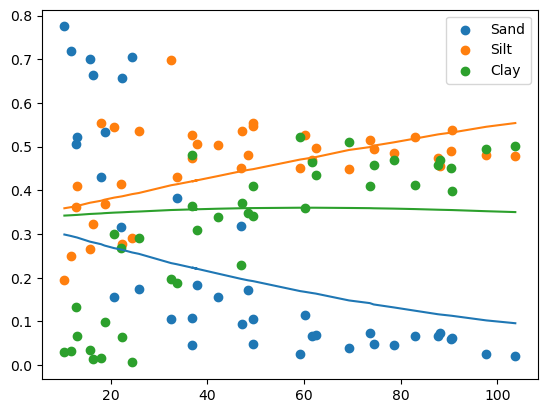

In [113]:
plt.scatter(X_arctic,Y_arctic[:,0],label='Sand')
plt.scatter(X_arctic,Y_arctic[:,1],label='Silt')
plt.scatter(X_arctic,Y_arctic[:,2],label='Clay')
plt.plot(X_arctic, mu_arctic)
plt.legend()
plt.show()

In [114]:
solution_arctic_bis.x

array([0.        , 0.01476894, 0.01090865, 1.67543086, 0.14038931])

## With bounds

In [151]:
#bounds = Bounds([0, -5, -5, -10, -1], [0, 5, 5, 10, 1])
bounds = Bounds([-np.inf, -np.inf, -np.inf, -np.inf, -1], [np.inf,np.inf,np.inf,np.inf, 1])

In [152]:
#beta0 = np.array([[0., 0.05, 0.06]])
beta0 = np.array([[0., 0., 0.]])
gamma0 = [0.]
rho0 = [0.]
params0 = np.concatenate([beta0.flatten(),gamma0, rho0])

In [117]:
%%time
solution_arctic_bis=minimize(f_spatial, params0, args=(X_arctic, Y_arctic, Z_arctic, W_arctic), bounds=bounds)

Wall time: 417 ms


In [118]:
solution_arctic_bis.message

'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'

In [119]:
beta_arctic = solution_arctic_bis.x[:n_features*n_classes].reshape((n_features,n_classes))
rho_arctic = solution_arctic_bis.x[-1]

In [120]:
X_new = np.arange(10.4,103.7,0.5)
X_new = np.array([[j] for j in X_new])

In [121]:
mu_arctic = dirichlet_regression.compute_mu_spatial(X_arctic, beta_arctic, rho_arctic, W_arctic)

gamma_var_arctic = solution_arctic_bis.x[n_features*n_classes:-1]
phi_arctic = np.exp(np.matmul(Z_arctic,gamma_var_arctic))

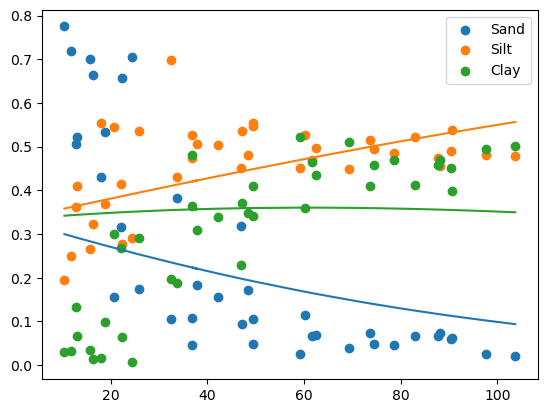

In [122]:
plt.scatter(X_arctic,Y_arctic[:,0],label='Sand')
plt.scatter(X_arctic,Y_arctic[:,1],label='Silt')
plt.scatter(X_arctic,Y_arctic[:,2],label='Clay')
plt.plot(X_arctic, mu_arctic)
plt.legend()
plt.show()

In [123]:
solution_arctic_bis.x

array([ 0.        ,  0.01729784,  0.01278831,  1.67542282, -0.00759197])

In [124]:
r2_score(Y_arctic,mu_arctic)

0.15160959764231197

### Find the best number of neighbors

In [166]:
list_r2 = []
list_ll = []

for nneighbors in range(3,36):
    neighbors = NearestNeighbors(n_neighbors=nneighbors).fit(X_arctic)
    W_arctic = neighbors.kneighbors_graph(X_arctic,mode='distance').toarray()
    W_arctic = W_arctic/W_arctic.sum(axis=1)[:,None]
    solution_arctic_bis=minimize(f_spatial, params0, args=(X_arctic, Y_arctic, Z_arctic, W_arctic), bounds=bounds)
    
    beta_arctic = solution_arctic_bis.x[:n_features*n_classes].reshape((n_features,n_classes))
    rho_arctic = solution_arctic_bis.x[-1]
    mu_arctic = dirichlet_regression.compute_mu_spatial(X_arctic, beta_arctic, rho_arctic, W_arctic)
    gamma_var_arctic = solution_arctic_bis.x[n_features*n_classes:-1]
    phi_arctic = np.exp(np.matmul(Z_arctic,gamma_var_arctic))
    
    list_r2.append(r2_score(Y_arctic,mu_arctic))
    list_ll.append(dirichlet_regression.dirichlet_loglikelihood(mu_arctic,phi_arctic,Y_arctic))

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4 is different from 1)

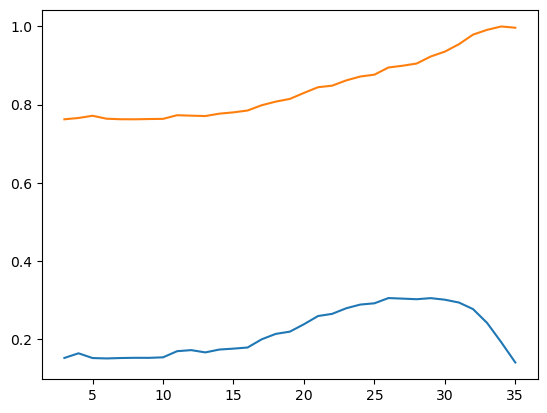

In [159]:
plt.plot(np.arange(3,36),list_r2)
plt.plot(np.arange(3,36),list_ll/np.max(list_ll))
plt.show()

## With an intercept

In [125]:
X_arctic_1 = np.ones((39,2))
X_arctic_1[:,1] = X_arctic[:,0]

In [126]:
X_arctic_1_bis = np.ones((39,2))
X_arctic_1_bis[:,1] = X_arctic[:,0]/np.max(X_arctic)

In [160]:
#beta0 = np.array([[0., -0.3, -1.1],[ 0., 0.05, 0.06]])
beta0 = np.array([[0., 0., 0.],[ 0., 0., 0.]])
gamma0 = [0]
rho0 = [0.]

params0 = np.concatenate([beta0.flatten(),gamma0,rho0])

In [161]:
min_bounds_1 = -np.inf*np.ones(len(params0)) 
max_bounds_1 = np.inf*np.ones(len(params0))
min_bounds_1[-1] = -1
max_bounds_1[-1] = 1
bounds = Bounds(min_bounds_1, max_bounds_1)

In [129]:
%%time
solution_arctic_bis=minimize(f_spatial, params0, args=(X_arctic_1_bis, Y_arctic, Z_arctic, W_arctic), bounds=bounds)

Wall time: 765 ms


In [130]:
solution_arctic_bis.message

'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'

In [131]:
beta_arctic_1 = solution_arctic_bis.x[:(n_features+1)*n_classes].reshape((n_features+1,n_classes))
rho_arctic_1 = solution_arctic_bis.x[-1]

In [132]:
X_new_1 = np.arange(10.4,103.7,0.5)
X_new_1 = np.array([[1., j] for j in X_new_1])

In [133]:
mu_arctic_1 = dirichlet_regression.compute_mu_spatial(X_arctic_1_bis, beta_arctic_1, rho_arctic_1, W_arctic)

gamma_var_arctic_1 = solution_arctic_bis.x[(n_features+1)*n_classes:-1]
phi_arctic_1 = np.exp(np.matmul(Z_arctic,gamma_var_arctic_1))

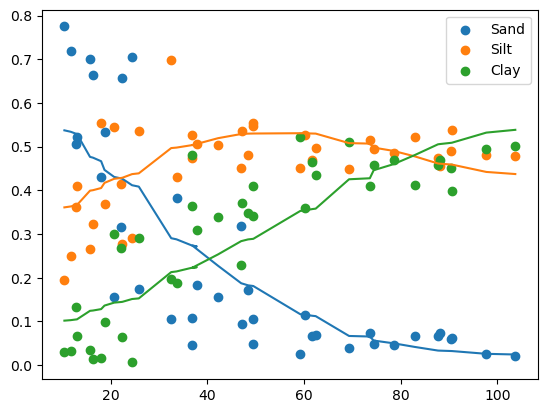

In [134]:
plt.scatter(X_arctic,Y_arctic[:,0],label='Sand')
plt.scatter(X_arctic,Y_arctic[:,1],label='Silt')
plt.scatter(X_arctic,Y_arctic[:,2],label='Clay')
plt.plot(X_arctic, mu_arctic_1)
plt.legend()
plt.show()

In [135]:
solution_arctic_bis.x

array([ 0.        , -0.2991497 , -0.81812532,  0.        ,  1.43550448,
        2.0790273 ,  2.63656655,  0.64630182])

In [136]:
r2_score(Y_arctic,mu_arctic_1)

0.5920259605753753

### Find the best number of neighbors

In [164]:
list_r2_1 = []
list_ll_1 = []

for nneighbors in range(3,36):
    neighbors = NearestNeighbors(n_neighbors=nneighbors).fit(X_arctic)
    W_arctic = neighbors.kneighbors_graph(X_arctic,mode='distance').toarray()
    W_arctic = W_arctic/W_arctic.sum(axis=1)[:,None]
    solution_arctic_bis=minimize(f_spatial, params0, args=(X_arctic_1_bis, Y_arctic, Z_arctic, W_arctic), bounds=bounds)
    
    beta_arctic_1 = solution_arctic_bis.x[:(n_features+1)*n_classes].reshape((n_features+1,n_classes))
    rho_arctic_1 = solution_arctic_bis.x[-1]
    mu_arctic_1 = dirichlet_regression.compute_mu_spatial(X_arctic_1_bis, beta_arctic_1, rho_arctic_1, W_arctic)
    gamma_var_arctic_1 = solution_arctic_bis.x[(n_features+1)*n_classes:-1]
    phi_arctic_1 = np.exp(np.matmul(Z_arctic,gamma_var_arctic_1))
    
    list_r2_1.append(r2_score(Y_arctic,mu_arctic_1))
    list_ll_1.append(dirichlet_regression.dirichlet_loglikelihood(mu_arctic_1,phi_arctic_1,Y_arctic))

C:\Users\46660461\Documents\GitHub\maupiti\dirichlet_regression.py:79: RuntimeWarning: overflow encountered in exp
  mu[i,j] = 1/np.sum(np.exp(MXbeta[i]-MXbeta[i,j]))
C:\Users\46660461\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\46660461\Documents\GitHub\maupiti\dirichlet_regression.py:79: RuntimeWarning: overflow encountered in exp
  mu[i,j] = 1/np.sum(np.exp(MXbeta[i]-MXbeta[i,j]))
C:\Users\46660461\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\46660461\Documents\GitHub\maupiti\dirichlet_regression.py:79: RuntimeWarning: overflow encountered in exp
  mu[i,j] = 1/np.sum(np.exp(MXbeta[i]-MXbeta[i,j]))
C:\Users\46660461\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\46660461\Documents\GitHub\maupiti\dir

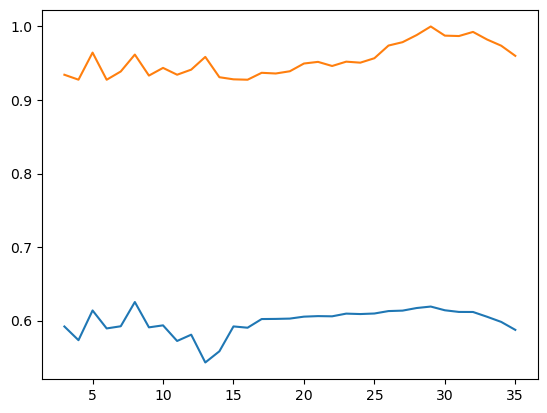

In [165]:
plt.plot(np.arange(3,36),list_r2_1)
plt.plot(np.arange(3,36),list_ll_1/np.max(list_ll_1))
plt.show()

In [171]:
np.max(list_r2_1)

0.6252796267725582

## With X^2

In [222]:
X_arctic_2 = np.ones((39,3))
X_arctic_2[:,1] = X_arctic[:,0]
X_arctic_2[:,2] = X_arctic[:,0]**2

In [223]:
X_arctic_2_bis = np.ones((39,3))
X_arctic_2_bis[:,1] = X_arctic[:,0]/np.max(X_arctic)
X_arctic_2_bis[:,2] = X_arctic_2_bis[:,1]**2

In [224]:
#beta0 = np.array([[ 0., -1.5, -3.], [0, 0.05, 0.1], [0., 0.01, 0.01]])
#gamma0 = [2.]
beta0 = np.array([[ 0., 0., 0.], [0, 0., 0.], [0., 0., 0.]])
gamma0 = [0.]
rho0 = [0.]
params0 = np.concatenate([beta0.flatten(),gamma0,rho0])

In [225]:
min_bounds_2 = -np.inf*np.ones(len(params0)) 
max_bounds_2 = np.inf*np.ones(len(params0))
min_bounds_2[-1] = -1
max_bounds_2[-1] = 1
bounds_2 = Bounds(min_bounds_2, max_bounds_2)

In [226]:
%%time
solution_arctic_bis=minimize(f_spatial, params0, args=(X_arctic_2_bis, Y_arctic, Z_arctic, W_arctic))

Wall time: 1.45 s


In [227]:
solution_arctic_bis.message

'Optimization terminated successfully.'

In [228]:
beta_arctic_2 = solution_arctic_bis.x[:(n_features+2)*n_classes].reshape((n_features+2,n_classes))
rho_arctic_2 = solution_arctic_bis.x[-1]

In [229]:
X_new_2 = np.arange(10.4,103.7,0.5)
X_new_2 = np.array([[1., j, j**2] for j in X_new_2])

In [230]:
mu_arctic_2 = dirichlet_regression.compute_mu_spatial(X_arctic_2_bis, beta_arctic_2, rho_arctic_2, W_arctic)

gamma_var_arctic_2 = solution_arctic_bis.x[(n_features+2)*n_classes:-1]
phi_arctic_2 = np.exp(np.matmul(Z_arctic,gamma_var_arctic_2))

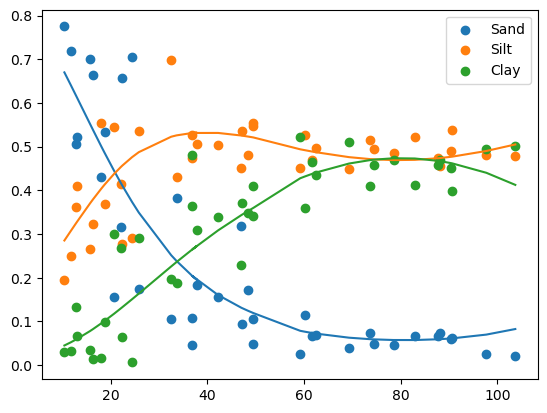

In [231]:
plt.scatter(X_arctic,Y_arctic[:,0],label='Sand')
plt.scatter(X_arctic,Y_arctic[:,1],label='Silt')
plt.scatter(X_arctic,Y_arctic[:,2],label='Clay')
plt.plot(X_arctic, mu_arctic_2)
plt.legend()
plt.show()

In [232]:
solution_arctic_bis.x

array([  0.        ,  -2.05978796,  -4.48694937,   0.        ,
        10.37853896,  17.01717909,   0.        ,  -6.62608264,
       -10.92576225,   2.94757955,   0.14484479])

In [233]:
dirichlet_regression.dirichlet_loglikelihood(mu_arctic_2,phi_arctic_2,Y_arctic)

91.32056051381062

In [234]:
r2_score(Y_arctic,mu_arctic_2)

0.6789171167782445

### Find the best number of neighbors

In [205]:
list_r2_2 = []
list_ll_2 = []

for nneighbors in range(3,36):
    neighbors = NearestNeighbors(n_neighbors=nneighbors).fit(X_arctic)
    W_arctic = neighbors.kneighbors_graph(X_arctic,mode='distance').toarray()
    W_arctic = W_arctic/W_arctic.sum(axis=1)[:,None]
    solution_arctic_bis=minimize(f_spatial, params0, args=(X_arctic_2_bis, Y_arctic, Z_arctic, W_arctic), bounds=bounds_2)
    
    beta_arctic_2 = solution_arctic_bis.x[:(n_features+2)*n_classes].reshape((n_features+2,n_classes))
    rho_arctic_2 = solution_arctic_bis.x[-1]
    mu_arctic_2 = dirichlet_regression.compute_mu_spatial(X_arctic_2_bis, beta_arctic_2, rho_arctic_2, W_arctic)
    gamma_var_arctic_2 = solution_arctic_bis.x[(n_features+2)*n_classes:-1]
    phi_arctic_2 = np.exp(np.matmul(Z_arctic,gamma_var_arctic_2))
    
    list_r2_2.append(r2_score(Y_arctic,mu_arctic_2))
    list_ll_2.append(dirichlet_regression.dirichlet_loglikelihood(mu_arctic_2,phi_arctic_2,Y_arctic))

C:\Users\46660461\Documents\GitHub\maupiti\dirichlet_regression.py:79: RuntimeWarning: overflow encountered in exp
  mu[i,j] = 1/np.sum(np.exp(MXbeta[i]-MXbeta[i,j]))
C:\Users\46660461\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\46660461\Documents\GitHub\maupiti\dirichlet_regression.py:79: RuntimeWarning: overflow encountered in exp
  mu[i,j] = 1/np.sum(np.exp(MXbeta[i]-MXbeta[i,j]))
C:\Users\46660461\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\46660461\Documents\GitHub\maupiti\dirichlet_regression.py:79: RuntimeWarning: overflow encountered in exp
  mu[i,j] = 1/np.sum(np.exp(MXbeta[i]-MXbeta[i,j]))
C:\Users\46660461\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\46660461\Documents\GitHub\maupiti\dir

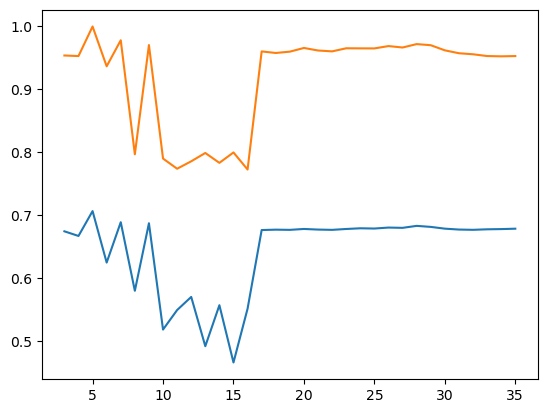

In [206]:
plt.plot(np.arange(3,36),list_r2_2)
plt.plot(np.arange(3,36),list_ll_2/np.max(list_ll_2))
plt.show()

In [207]:
np.max(list_r2_2)

0.7068595788328524

In [208]:
np.max(list_ll_2)

95.8231904617739

# Using the derivatives

In [303]:
def fprime_spatial(x, X, Y, Z, W, epsilon=0):
    K = X.shape[-1]
    J = Y.shape[-1]
    n = X.shape[0]
    beta = x[:K*J].reshape((K,J))
    beta[:,0] = 0
    gamma_var = x[K*J:-1]
    rho = x[-1]
    Minv = np.linalg.inv(np.identity(n) - rho*W)
    MinvX = np.matmul(Minv,X)
    mu = dirichlet_regression.compute_mu_spatial_2(X, beta, rho=rho, W=W, MinvX=MinvX)
    phi = np.exp(np.matmul(Z,gamma_var))

    beta_grad = dirichlet_regression.dirichlet_gradient_wrt_beta(mu, phi, MinvX, Y, epsilon=epsilon)
    beta_grad[:,0] = 0
    gamma_grad = dirichlet_regression.dirichlet_derivative_wrt_gamma(mu, phi, beta, MinvX, Y, Z, epsilon=epsilon)
    rho_derivative = dirichlet_regression.dirichlet_derivative_wrt_rho(mu, phi, Minv, beta, W, X, Y, Z, MinvX, epsilon=epsilon)
    return(-np.concatenate([beta_grad.flatten(),gamma_grad,rho_derivative]))

In [ ]:
# TODO : CHECK IF IT WORKS

In [249]:
h=0.000001
params0_h = np.copy(params0)
params0_h[-2] += h 
(f_arctic(params0_h, X_arctic_2, Y_arctic, Z_arctic)-f_arctic(params0, X_arctic_2, Y_arctic, Z_arctic))/h

271402.53057746124

In [250]:
fprime_arctic(params0, X_arctic_2, Y_arctic, Z_arctic)

array([-0.00000000e+00,  2.44803858e+00,  4.54959527e+01, -0.00000000e+00,
       -1.40671295e+03,  3.41001611e+03, -0.00000000e+00, -1.49382795e+05,
        2.71310732e+05,  4.12946026e+01])

In [412]:
%%time
solution_arctic = minimize(f_arctic, params0, args=(X_arctic_2, Y_arctic, Z_arctic), jac=fprime_arctic)

C:\Users\46660461\Documents\GitHub\maupiti\dirichlet_regression.py:29: RuntimeWarning: overflow encountered in exp
  mu[i,j] = 1/np.sum(np.exp(Xbeta[i]-Xbeta[i,j]))
C:\Users\46660461\Documents\GitHub\maupiti\dirichlet_regression.py:38: RuntimeWarning: overflow encountered in exp
  I_n = np.identity(n)
C:\Users\46660461\Documents\GitHub\maupiti\dirichlet_regression.py:29: RuntimeWarning: overflow encountered in exp
  mu[i,j] = 1/np.sum(np.exp(Xbeta[i]-Xbeta[i,j]))


Wall time: 426 ms


In [413]:
solution_arctic.message

'Desired error not necessarily achieved due to precision loss.'

In [414]:
beta_arctic_2 = solution_arctic.x[:(n_features+2)*n_classes].reshape((n_features+2,n_classes))

In [415]:
mu_arctic_2 = dirichlet_regression.compute_mu(X_new_2, beta_arctic_2)

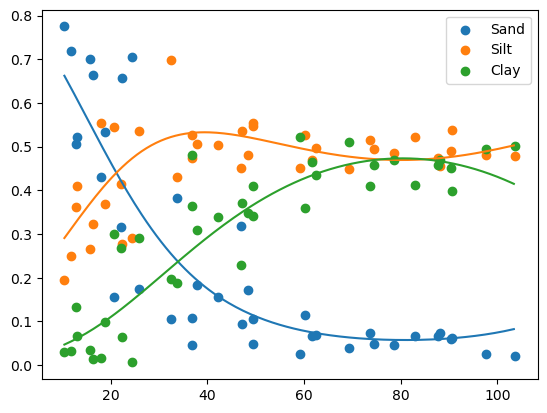

In [416]:
plt.scatter(X_arctic,Y_arctic[:,0],label='Sand')
plt.scatter(X_arctic,Y_arctic[:,1],label='Silt')
plt.scatter(X_arctic,Y_arctic[:,2],label='Clay')
plt.plot(X_new, mu_arctic_2)
plt.legend()
plt.show()

## My GD

In [80]:
params0

array([ 0.  , -1.5 , -4.  ,  0.  ,  0.05,  0.1 ,  0.  ,  0.01,  0.01,
        2.  ])

In [81]:
def gradientDescent(X, Y, Z, params_0, learning_rate=0.001, nitermax=1000, tolmax=1e-3,epsilon=0):
    K = X.shape[-1]
    J = Y.shape[-1]
    current_param = params_0
    list_likelihoods = []
    list_gradients = []
    list_params = [current_param]
    
    niter=0
    tol=1
    
    current_beta = current_param[:K*J].reshape((K,J))
    current_beta[:,0] = 0
    current_gamma_var = current_param[K*J:]

    while (tol > tolmax) & (niter<nitermax):
        current_phi = np.exp(np.matmul(Z,current_gamma_var))
        current_mu = dirichlet_regression.compute_mu(X, current_beta)
        list_likelihoods.append(dirichlet_regression.dirichlet_loglikelihood(current_mu,current_phi,Y))
        
        grad = fprime_arctic(current_param,X,Y,Z,epsilon=epsilon)
        
        list_gradients.append(grad)
        # we want to maximize the function, so we add the gradient
        old_param = np.copy(current_param)
        current_param = current_param - learning_rate * grad
        current_beta = current_param[:K*J].reshape((K,J))
        current_beta[:,0] = 0
        current_gamma_var = current_param[K*J:]
        current_param = np.concatenate([current_beta.flatten(),current_gamma_var])
        list_params.append(current_param)
        
        niter+=1
        tol = np.sum((current_param - old_param)**2)**0.5
        
    print('Nb of iterations:',niter)
    return(list_params, list_likelihoods, list_gradients)

In [394]:
%%time
list_params, list_likelihoods, list_gradients=gradientDescent(X_arctic_2_bis, Y_arctic, Z_arctic, 
                                                              params0, 
                                                              nitermax = 10000, learning_rate=2e-2, tolmax=1e-2)

Nb of iterations: 10000
Wall time: 34.2 s


In [395]:
solution_arctic = list_params[-1]

In [396]:
beta_arctic_2 = solution_arctic[:(n_features+2)*n_classes].reshape((n_features+2,n_classes))
beta_arctic_2

array([[ 0.        , -0.63579566, -5.69503471],
       [ 0.        ,  8.03362598, 13.46590533],
       [ 0.        , -4.92296251, -9.19415713]])

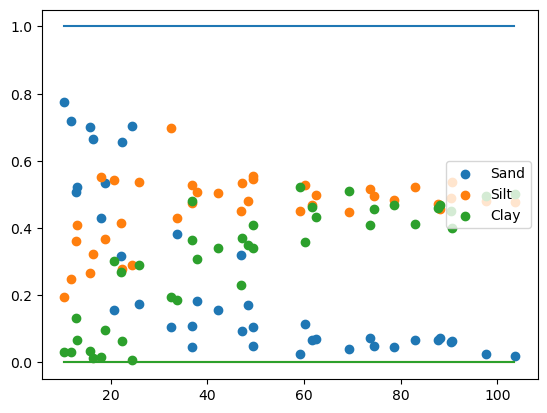

In [399]:
mu_arctic_2 = dirichlet_regression.compute_mu(X_new_2, beta_arctic_2)

#gamma_var_arctic_2 = solution_arctic_bis[(n_features+2)*n_classes:]
#phi_arctic_2 = np.exp(np.matmul(Z_arctic,gamma_var_arctic_2))

plt.scatter(X_arctic,Y_arctic[:,0],label='Sand')
plt.scatter(X_arctic,Y_arctic[:,1],label='Silt')
plt.scatter(X_arctic,Y_arctic[:,2],label='Clay')
plt.plot(X_new, mu_arctic_2)
plt.legend()
plt.show()

In [397]:
X_new_2_bis = np.arange(10.4,103.7,0.5)
X_new_2_bis = np.array([[1., j/np.max(X_arctic), (j/np.max(X_arctic))**2] for j in X_new_2_bis])

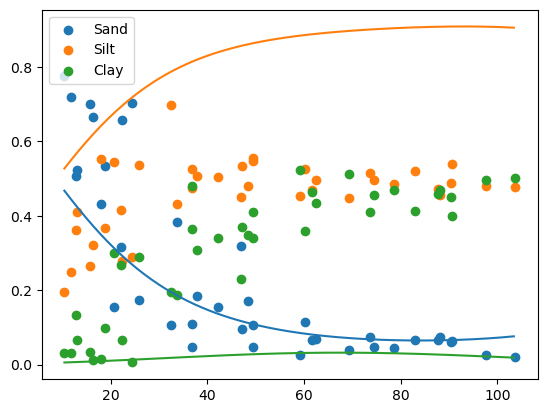

In [398]:
mu_arctic_2 = dirichlet_regression.compute_mu(X_new_2_bis, beta_arctic_2)

plt.scatter(X_arctic,Y_arctic[:,0],label='Sand')
plt.scatter(X_arctic,Y_arctic[:,1],label='Silt')
plt.scatter(X_arctic,Y_arctic[:,2],label='Clay')
plt.plot(X_new, mu_arctic_2)
plt.legend()
plt.show()

### With hessian

In [465]:
def fhessian(x, X, Y, Z):
    K = X.shape[-1]
    J = Y.shape[-1]
    beta = x[:K*J].reshape((K,J))
    beta[:,0] = 0
    gamma_var = x[K*J:]
    #mu = dirichlet_regression.compute_mu(X, beta)
    mu = dirichlet_regression.compute_mu_2(X, beta)
    phi = np.exp(np.matmul(Z,gamma_var))
    if len(phi.shape)==1:
        K_phi=1
    else:
        K_phi = phi.shape[-1]
    hessian = np.zeros((K*J+1,K*J+1))
    #beta_hess = dirichlet_regression.dirichlet_hessian_wrt_beta(mu, phi, X, Y).reshape((K*J,K*J))
    beta_hess = dirichlet_hessian_wrt_beta_2(mu, phi, X, Y).reshape((K*J,K*J))
    #gamma_hess = dirichlet_regression.dirichlet_hessian_wrt_gamma(mu, phi, beta, X, Y, Z)
    gamma_hess = dirichlet_regression.dirichlet_hessian_wrt_gamma_2(mu, phi, beta, X, Y, Z)
    #beta_gamma_derivative = dirichlet_regression.dirichlet_second_derivative_beta_gamma(mu, phi, beta, X, Y, Z).reshape((K_phi,K*J))
    beta_gamma_derivative = dirichlet_regression.dirichlet_second_derivative_beta_gamma_2(mu, phi, beta, X, Y, Z).reshape((K_phi,K*J))
    
    # we set to 0 the first columns of the betas
    for k in range(0,K*J,J):
        beta_hess[k,:] = 0
        beta_hess[:,k] = 0.
        beta_gamma_derivative[:,k] = 0.
    hessian[:K*J,:K*J] = beta_hess
    hessian[K*J:,K*J:] = gamma_hess
    hessian[:K*J,K*J:] = beta_gamma_derivative.transpose()
    hessian[K*J:,:K*J] = beta_gamma_derivative
    return(-hessian)

In [320]:
fprime_arctic(params0, X_arctic_2, Y_arctic, Z_arctic)

array([-0.00000000e+00,  2.44803858e+00,  4.54959527e+01, -0.00000000e+00,
       -1.40671295e+03,  3.41001611e+03, -0.00000000e+00, -1.49382795e+05,
        2.71310732e+05,  4.12946026e+01])

In [316]:
h=0.000001
params0_h = np.copy(params0)
params0_h[5] += h 
(fprime_arctic(params0_h, X_arctic_2, Y_arctic, Z_arctic)-fprime_arctic(params0, X_arctic_2, Y_arctic, Z_arctic))/h

array([ 0.00000000e+00, -1.98728330e+03,  1.99227742e+03,  0.00000000e+00,
       -8.67261840e+04,  8.67582302e+04,  0.00000000e+00, -4.04627617e+06,
        4.04609504e+06,  1.90396482e+03])

In [317]:
test_hess = fhessian(params0, X_arctic_2, Y_arctic, Z_arctic)

In [466]:
%%time
solution_arctic = minimize(f_arctic, params0, args=(X_arctic_2, Y_arctic, Z_arctic), jac=fprime_arctic, hess=fhessian, method='newton-cg', tol=1e-8)

Wall time: 3.72 s


In [467]:
solution_arctic.message

'Optimization terminated successfully.'

In [468]:
solution_arctic.x

array([ 0.00000000e+00, -1.58878800e+00, -3.95380850e+00,  0.00000000e+00,
        8.73567665e-02,  1.46257966e-01,  0.00000000e+00, -5.22072385e-04,
       -8.87909711e-04,  2.88269991e+00])

In [469]:
beta_arctic_2 = solution_arctic.x[:(n_features+2)*n_classes].reshape((n_features+2,n_classes))

mu_arctic_2 = dirichlet_regression.compute_mu(X_new_2, beta_arctic_2)

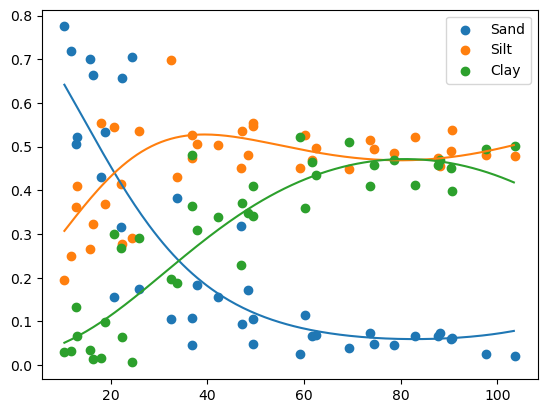

In [470]:
plt.scatter(X_arctic,Y_arctic[:,0],label='Sand')
plt.scatter(X_arctic,Y_arctic[:,1],label='Silt')
plt.scatter(X_arctic,Y_arctic[:,2],label='Clay')
plt.plot(X_new, mu_arctic_2)
plt.legend()
plt.show()

## My GD with hessian

In [105]:
def gradientDescentNewton(X, Y, Z, params_0, nitermax=1000, tolmax=1e-3,epsilon=0):
    K = X.shape[-1]
    J = Y.shape[-1]
    current_param = params_0
    list_likelihoods = []
    list_gradients = []
    list_params = [current_param]
    
    niter=0
    tol=1
    
    current_beta = current_param[:K*J].reshape((K,J))
    current_beta[:,0] = 0
    current_gamma_var = current_param[K*J:]

    while (tol > tolmax) & (niter<nitermax):
        current_phi = np.exp(np.matmul(Z,current_gamma_var))
        current_mu = dirichlet_regression.compute_mu(X, current_beta)
        list_likelihoods.append(dirichlet_regression.dirichlet_loglikelihood(current_mu,current_phi,Y))
        
        grad = fprime_arctic(current_param,X,Y,Z,epsilon=epsilon)
        
        hess = fhessian(current_param, X, Y, Z)
        hess_inv = np.linalg.pinv(hess)
        
        list_gradients.append(grad)
        # we want to maximize the function, so we add the gradient
        old_param = np.copy(current_param)
        print(np.matmul(hess_inv,grad))
        current_param = current_param - np.matmul(hess_inv,grad)
        current_beta = current_param[:K*J].reshape((K,J))
        current_beta[:,0] = 0
        current_gamma_var = current_param[K*J:]
        current_param = np.concatenate([current_beta.flatten(),current_gamma_var])
        print('---')
        print(current_param)
        list_params.append(current_param)
        
        niter+=1
        tol = np.sum((current_param - old_param)**2)**0.5
        
    print('Nb of iterations:',niter)
    return(list_params, list_likelihoods, list_gradients)

In [315]:
%%time
list_params, list_likelihoods, list_gradients=gradientDescentNewton(X_arctic_2, Y_arctic, Z_arctic, 
                                                              params0, nitermax = 1000, tolmax=1e-4)

[ 0.00000000e+00 -2.43508328e+04 -2.46927060e+04 -8.53629308e-08
  3.45521684e+03  3.47671845e+03 -5.26314627e-09 -1.12512217e+02
 -1.12783211e+02 -4.93392233e+01]
---
[    0.         24349.33279153 24688.7060191      0.
 -3455.16683808 -3476.61844663     0.           112.52221747
   112.79321107    51.33922326]


C:\Users\46660461\Documents\GitHub\maupiti\dirichlet_regression.py:15: RuntimeWarning: overflow encountered in exp
  exp_Xbeta = np.exp(Xbeta)
C:\Users\46660461\Documents\GitHub\maupiti\dirichlet_regression.py:18: RuntimeWarning: invalid value encountered in true_divide
  mu[i,:] = exp_Xbeta[i,:]/sum_exp_Xbeta[i]
C:\Users\46660461\Documents\GitHub\maupiti\dirichlet_regression.py:38: RuntimeWarning: overflow encountered in exp
  I_n = np.identity(n)
C:\Users\46660461\Documents\GitHub\maupiti\dirichlet_regression.py:29: RuntimeWarning: overflow encountered in exp
  mu[i,j] = 1/np.sum(np.exp(Xbeta[i]-Xbeta[i,j]))
C:\Users\46660461\AppData\Local\Temp\ipykernel_12280\3350967127.py:68: RuntimeWarning: overflow encountered in double_scalars
  phi_trigamma_alpha_c = phi[i]*trigamma_alpha[c]
C:\Users\46660461\AppData\Local\Temp\ipykernel_12280\3350967127.py:69: RuntimeWarning: invalid value encountered in double_scalars
  hessian[p,d,q,c] += phi_Xip_muid_Xiq*mu[i,c] * ( 2*digamma_alpha[c] - 2*l

LinAlgError: SVD did not converge

In [110]:
beta_test = np.array([[0.00000000e+00, -1.68702777e+02,  9.11259508e+02],  
                      [0.00000000e+00, 5.37880187e+02, -3.71678045e+03] , 
                      [0.00000000e+00, -4.06042729e+02, 2.77243089e+03]])

In [111]:
mu_test = dirichlet_regression.compute_mu_2(X_arctic_2,beta_test)

C:\Users\46660461\Documents\GitHub\maupiti\dirichlet_regression.py:29: RuntimeWarning: overflow encountered in exp
  mu[i,j] = 1/np.sum(np.exp(Xbeta[i]-Xbeta[i,j]))


In [112]:
phi_test = np.exp(np.matmul(Z_arctic,[-1.54306869e+00]))

In [593]:
phi_test[8]*mu_test[8]

array([False, False, False])

In [113]:
def trigamma_func(z):
    S=0
    for n in range(10000):
        S+=1/(z+n)**2
    return S

def z_times_trigamma_func(z):
    S=0
    for n in range(10000):
        S+=1/( z + 2*n + (n**2)/z )
    return S

def a_times_trigamma_func(a,z):
    S=0
    try:
        for n in range(10000):
            S+=1/( z*(z/a) + (2*z*n)/a + (n**2)/a )
    except ZeroDivisionError:
        S=1e305
    return S

In [510]:
a_times_trigamma_func(0.2, 2e-247)

1e+305

In [236]:
def dirichlet_hessian_wrt_beta_2(mu, phi, X, Y, alpha=None, epsilon=0):
    K = np.shape(X)[1] #nb of features
    J = np.shape(Y)[1] #nb of classes
    n = np.shape(Y)[0] 
    hessian = np.zeros((K,J,K,J))
    if alpha is None:
        alpha = np.copy(mu)
        for j in range(J):
            alpha[:,j] = phi*mu[:,j]
    for i in range(n):
        digamma_alpha = digamma(alpha[i])
        digamma_alpha[np.isinf(digamma_alpha)] = -1e305

        trigamma_alpha = polygamma(1,alpha[i])
        trigamma_alpha[np.isinf(trigamma_alpha)] = 1e305
        
        #mu_2_trigamma = a_times_trigamma_func(mu[i]**2,alpha[i])
        #if math.isinf(trigamma_alpha):
        #    mu_2_trigamma = a_times_trigamma_func(mu[i]**2,alpha[i])
        #else:
        mu_2_trigamma = mu[i]**2*trigamma_alpha
        mu_2_trigamma[mu[i]**2==0] = 0
        phi_sum_mu_2_trigamma = phi[i]*np.sum(mu_2_trigamma)
        
        logY = np.log(Y[i]+epsilon)
        sum_mu_log = 2*np.sum(mu[i]*logY)
        
        mu_digamma_alpha = mu[i]*digamma_alpha
        mu_digamma_alpha[mu[i]==0] = 0
        sum_mu_digamma = 2*np.sum(mu_digamma_alpha)
        
        mu_digamma_log = mu[i]*(digamma_alpha-logY)
        #mu_digamma_log[mu[i]==0] = 0
        sum_mu_digamma_log = np.sum(mu_digamma_log)
        for p in range(K):
            phi_Xip = phi[i]*X[i,p]
            for d in range(J):
                phi_Xip_muid = phi_Xip*mu[i,d]
                if alpha[i,d]==0:
                    alpha_times_trigamma_alpha = np.zeros(np.shape(trigamma_alpha[d]))
                else:
                    if math.isinf(trigamma_alpha[d]):
                        alpha_times_trigamma_alpha = np.array(a_times_trigamma_func(alpha[i,d],alpha[i,d]))
                    else:
                        alpha_times_trigamma_alpha = alpha[i,d]*trigamma_alpha[d]
                for q in range(K):
                    phi_Xip_muid_Xiq = phi_Xip_muid*X[i,q]
                    for c in range(J):
                        if c!=d:
                            if alpha[i,c]==0:
                                alpha_c_trigamma_alpha_c = 0
                            elif math.isinf(trigamma_alpha[c]):
                                alpha_c_trigamma_alpha_c = a_times_trigamma_func(alpha[i,c],alpha[i,c])
                            else:
                                alpha_c_trigamma_alpha_c = alpha[i,c]*trigamma_alpha[c]
                            hessian[p,d,q,c] += phi_Xip_muid_Xiq*mu[i,c] * ( digamma_alpha[c] + digamma_alpha[d]
                                                                           - logY[c] - logY[d]
                                                                           + alpha_c_trigamma_alpha_c + alpha_times_trigamma_alpha
                                                                           - phi_sum_mu_2_trigamma 
                                                                           + sum_mu_log
                                                                           - sum_mu_digamma )
                        else:
                            
                            if math.isinf(trigamma_alpha[c]):
                                #phi_trigamma_alpha_c = np.array(a_times_trigamma_func(phi[i],alpha[i,c]))
                                phi_trigamma_alpha_c = phi[i]*1e305
                            else:
                                phi_trigamma_alpha_c = phi[i]*trigamma_alpha[c]
                            hessian[p,d,q,c] += phi_Xip_muid_Xiq*mu[i,c] * ( 2*digamma_alpha[c] - 2*logY[c] 
                                                                           + 2*alpha_times_trigamma_alpha
                                                                           - phi_sum_mu_2_trigamma
                                                                           + sum_mu_log
                                                                           - sum_mu_digamma
                                                                           - phi_trigamma_alpha_c)
                            hessian[p,d,q,c] += phi_Xip_muid_Xiq * (sum_mu_digamma_log - digamma_alpha[c] + logY[c] )
    # fill the symmetric values we didn't compute
    #for p in range(K):
    #    for d in range(J):
    #        for q in range(p):
    #            for c in range(J):
    #                hessian[p,d,q,c] = hessian[q,c,p,d]
    return hessian

In [486]:
%%time
_ = dirichlet_regression.dirichlet_hessian_wrt_beta(mu_test, phi_test, X_arctic_2_bis, Y_arctic)

Wall time: 10 ms


In [108]:
mu_test_bis = np.array([1.04578539e-246, 2.54998312e-298, 1.00000000e+000])
mu_test_bis**2

array([0., 0., 1.])

In [211]:
beta_test = np.array([[0.00000000e+00, -1.68702777e+02,  9.11259508e+02], 
                                                               [0.00000000e+00, 5.37880187e+02, -3.71678045e+03], 
                                                               [0.00000000e+00, -4.06042729e+02, 2.77243089e+03]])
mu_test = dirichlet_regression.compute_mu_2(X_arctic_2_bis,beta_test)
phi_test = np.exp(np.matmul(Z_arctic,[-1.54306869e+00]))

In [237]:
%%time
dirichlet_hessian_wrt_beta_2(mu_test, phi_test, X_arctic_2_bis, Y_arctic)

Wall time: 1.37 ms


array([[[[ 5.11823194e+00,  5.47337622e-01, -5.66556957e+00],
         [ 2.45255953e-01,  4.16876520e-01, -6.62132473e-01],
         [-2.57690694e-01,  3.23948082e-01, -6.62573887e-02]],

        [[ 5.47337622e-01,  8.45266218e+00, -8.99999980e+00],
         [ 4.16876520e-01,  9.07135012e-01, -1.32401153e+00],
         [ 3.23948082e-01, -1.20087834e-01, -2.03860248e-01]],

        [[-5.66556957e+00, -8.99999980e+00,  1.46655694e+01],
         [-6.62132473e-01, -1.32401153e+00,  1.98614401e+00],
         [-6.62573887e-02, -2.03860248e-01,  2.70117637e-01]]],


       [[[ 2.45255953e-01,  4.16876520e-01, -6.62132473e-01],
         [-2.57690694e-01,  3.23948082e-01, -6.62573887e-02],
         [-2.52820277e-01,  2.55093768e-01, -2.27349083e-03]],

        [[ 4.16876520e-01,  9.07135012e-01, -1.32401153e+00],
         [ 3.23948082e-01, -1.20087834e-01, -2.03860248e-01],
         [ 2.55093768e-01, -2.22396854e-01, -3.26969134e-02]],

        [[-6.62132473e-01, -1.32401153e+00,  1.98614401e+0

In [238]:
%%time
dirichlet_regression.dirichlet_second_derivative_beta_gamma_2(mu_test, phi_test, beta_test, X_arctic_2_bis, Y_arctic, Z_arctic)

Wall time: 3.01 ms


array([[[  5.93566426,   9.07093694, -15.0066012 ],
        [  0.71990516,   1.37673711,  -2.09664227],
        [  0.06164781,   0.24427255,  -0.30592035]]])

In [241]:
test_param = np.array([ 0.00000000e+00, -1.68702777e+02,  9.11259508e+02,  0.00000000e+00,
  5.37880187e+02, -3.71678045e+03,  0.00000000e+00, -4.06042729e+02,
  2.77243089e+03, -1.54306869e+00])
fhessian(test_param, X_arctic_2_bis, Y_arctic, Z_arctic)

array([[-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00],
       [-0.00000000e+00, -8.45266218e+00,  8.99999980e+00,
        -0.00000000e+00, -9.07135012e-01,  1.32401153e+00,
        -0.00000000e+00,  1.20087834e-01,  2.03860248e-01,
        -9.07093694e+00],
       [-0.00000000e+00,  8.99999980e+00, -1.46655694e+01,
        -0.00000000e+00,  1.32401153e+00, -1.98614401e+00,
        -0.00000000e+00,  2.03860248e-01, -2.70117637e-01,
         1.50066012e+01],
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00],
       [-0.00000000e+00, -9.07135012e-01,  1.32401153e+00,
        -0.00000000e+00,  1.20087834e-01,  2.03860248e-01,
        -0.00000000e+00,  2.22396854e-01,  3.26969134e-02,
        -1.

In [310]:
fprime_arctic(test_param_h, X_arctic_2, Y_arctic, Z_arctic)

[[1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 [1.e-305 1.e-305 1.e+000]
 

C:\Users\46660461\Documents\GitHub\maupiti\dirichlet_regression.py:38: RuntimeWarning: overflow encountered in exp
  I_n = np.identity(n)


array([-0.00000000e+00, -3.90000000e+01,  7.80000000e+01, -0.00000000e+00,
       -1.87350000e+03,  3.74700000e+03, -0.00000000e+00, -1.19953910e+05,
        2.39907820e+05, -6.47185147e+01])

In [321]:
fprime_arctic(test_param, X_arctic_2_bis, Y_arctic, Z_arctic)

array([ -0.        , -12.38383635,   3.38132457,  -0.        ,
        -0.38892245, -10.29110409,  -0.        ,   0.75062587,
        -9.58037658, -59.93704478])

In [312]:
test_param

array([ 0.00000000e+00, -1.68702777e+02,  9.11259508e+02,  0.00000000e+00,
        5.37880187e+02, -3.71678045e+03,  0.00000000e+00, -4.06042729e+02,
        2.77243089e+03, -1.54306869e+00])

In [329]:
h=0.0000001
test_param_h = np.copy(test_param)
test_param_h[4] += h 
(fprime_arctic(test_param_h, X_arctic_2_bis, Y_arctic, Z_arctic)-fprime_arctic(test_param, X_arctic_2_bis, Y_arctic, Z_arctic))/h

array([ 0.        ,  0.41687633,  0.        ,  0.        ,  0.32394787,
        0.        ,  0.        ,  0.25509361,  0.        , -0.05272561])

In [324]:
test_hess = fhessian(test_param, X_arctic_2_bis, Y_arctic, Z_arctic)
test_hess

array([[-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00],
       [-0.00000000e+00, -8.45266218e+00,  8.99999980e+00,
        -0.00000000e+00, -9.07135012e-01,  1.32401153e+00,
        -0.00000000e+00,  1.20087834e-01,  2.03860248e-01,
        -9.07093694e+00],
       [-0.00000000e+00,  8.99999980e+00, -1.46655694e+01,
        -0.00000000e+00,  1.32401153e+00, -1.98614401e+00,
        -0.00000000e+00,  2.03860248e-01, -2.70117637e-01,
         1.50066012e+01],
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00],
       [-0.00000000e+00, -9.07135012e-01,  1.32401153e+00,
        -0.00000000e+00,  1.20087834e-01,  2.03860248e-01,
        -0.00000000e+00,  2.22396854e-01,  3.26969134e-02,
        -1.

In [320]:
test_beta = np.array([[0.00000000e+00, -1.68702777e+02,  9.11259508e+02],  [0.00000000e+00,
  5.37880187e+02, -3.71678045e+03],  [0.00000000e+00, -4.06042729e+02, 2.77243089e+03]])
mu_test = dirichlet_regression.compute_mu_2(X_arctic_2_bis, test_beta)

In [285]:
solution_arctic = list_params[-1]

beta_arctic_2 = solution_arctic[:(n_features+2)*n_classes].reshape((n_features+2,n_classes))
beta_arctic_2

array([[ 0.00000000e+00, -4.81525199e+00, -6.95162005e+00],
       [ 0.00000000e+00,  4.94488327e-01,  5.17653466e-01],
       [ 0.00000000e+00, -5.34681144e-03, -4.97890760e-03]])

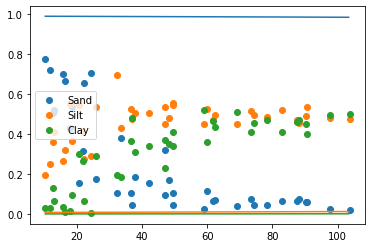

In [286]:
mu_arctic_2 = dirichlet_regression.compute_mu(X_new_2_bis, beta_arctic_2)

#gamma_var_arctic_2 = solution_arctic_bis[(n_features+2)*n_classes:]
#phi_arctic_2 = np.exp(np.matmul(Z_arctic,gamma_var_arctic_2))

plt.scatter(X_arctic,Y_arctic[:,0],label='Sand')
plt.scatter(X_arctic,Y_arctic[:,1],label='Silt')
plt.scatter(X_arctic,Y_arctic[:,2],label='Clay')
plt.plot(X_new, mu_arctic_2)
plt.legend()
plt.show()